## Import the library

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

from xgboost import XGBClassifier
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

INPUT_PATH = "input/"
OUTPUT_PATH = "output/"

## Prepare dataset

In [22]:
data = pd.read_csv(INPUT_PATH + "train.csv")

data.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

### Quick EDA

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


### Nan values

In [24]:
data.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

### Cleaning data function
Implement a function for cleaning up data (for the test set later as well)
- Remove features like PassengerId/Name which is not effect the outcome.
- Handling 'nan' values: 
    - For the 'str' type create another 'Unknown' values.
    - For the 'int' type replace with 0.


In [25]:
def cleanData(data: pd.DataFrame) -> pd.DataFrame:
    # Remove irrelevent features     
    data = data.drop(["PassengerId", "Name"], axis=1)
    
    # Split the Cabin feature into Deck/Num/Side    
    data[["CabinDeck", "CabinNum", "CabinSide"]] = data['Cabin'].str.split('/', expand=True)
    
    # Replace nan with approriate values:
    # For 'str' type features:
    data[['HomePlanet', 'CabinDeck', 'CabinSide', 'Destination']] = data[['HomePlanet', 'CabinDeck', 'CabinSide', 'Destination']].fillna('Unknown')
    
    # For 'int' type features    
    data.fillna(0, inplace=True)

    data[["CryoSleep", "VIP", "CabinNum"]] = data[["CryoSleep", "VIP", "CabinNum"]].astype(int)
    data.drop('Cabin', axis=1, inplace=True)

    enc = OneHotEncoder()
    enc.fit(data[['HomePlanet','Destination', 'CabinSide']])
    data[enc.get_feature_names_out()] = enc.transform(data[['HomePlanet','Destination', 'CabinSide']]).toarray()
    data.drop(['HomePlanet','Destination', 'CabinSide'],axis=1, inplace=True)

    data.drop('CabinDeck', axis=1, inplace=True)
    
    return data

In [26]:
data = cleanData(data)
data.head()

CryoSleep   Age  VIP  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
0          0  39.0    0          0.0        0.0           0.0     0.0     0.0   
1          0  24.0    0        109.0        9.0          25.0   549.0    44.0   
2          0  58.0    1         43.0     3576.0           0.0  6715.0    49.0   
3          0  33.0    0          0.0     1283.0         371.0  3329.0   193.0   
4          0  16.0    0        303.0       70.0         151.0   565.0     2.0   

   Transported  CabinNum  ...  HomePlanet_Europa  HomePlanet_Mars  \
0        False         0  ...                1.0              0.0   
1         True         0  ...                0.0              0.0   
2        False         0  ...                1.0              0.0   
3        False         0  ...                1.0              0.0   
4         True         1  ...                0.0              0.0   

   HomePlanet_Unknown  Destination_55 Cancri e  Destination_PSO J318.5-22  \
0                 0.0                      0.0                        0.0   
1                 0.0                      0.0                        0.0   
2                 0.0                      0.0                        0.0   
3                 0.0                      0.0                        0.0   
4                 0.0                      0.0                        0.0   

   Destination_TRAPPIST-1e  Destination_Unknown  CabinSide_P  CabinSide_S  \
0                      1.0                  0.0          1.0          0.0   
1                      1.0                  0.0          0.0          1.0   
2                      1.0                  0.0          0.0          1.0   
3                      1.0                  0.0          0.0          1.0   
4                      1.0                  0.0          0.0          1.0   

   CabinSide_Unknown  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  

[5 rows x 21 columns]

#### Bar chart for label output
Label column: Transported

<Axes: xlabel='Transported'>

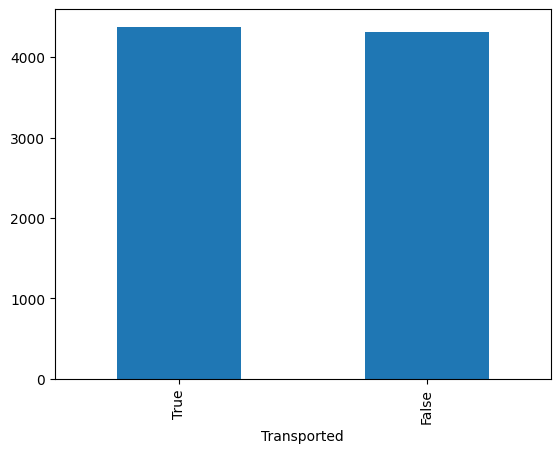

In [27]:
data['Transported'].value_counts().plot(kind='bar')

#### Numerical data distribution
Plot all the numerical columns

<Axes: xlabel='Spa', ylabel='Frequency'>

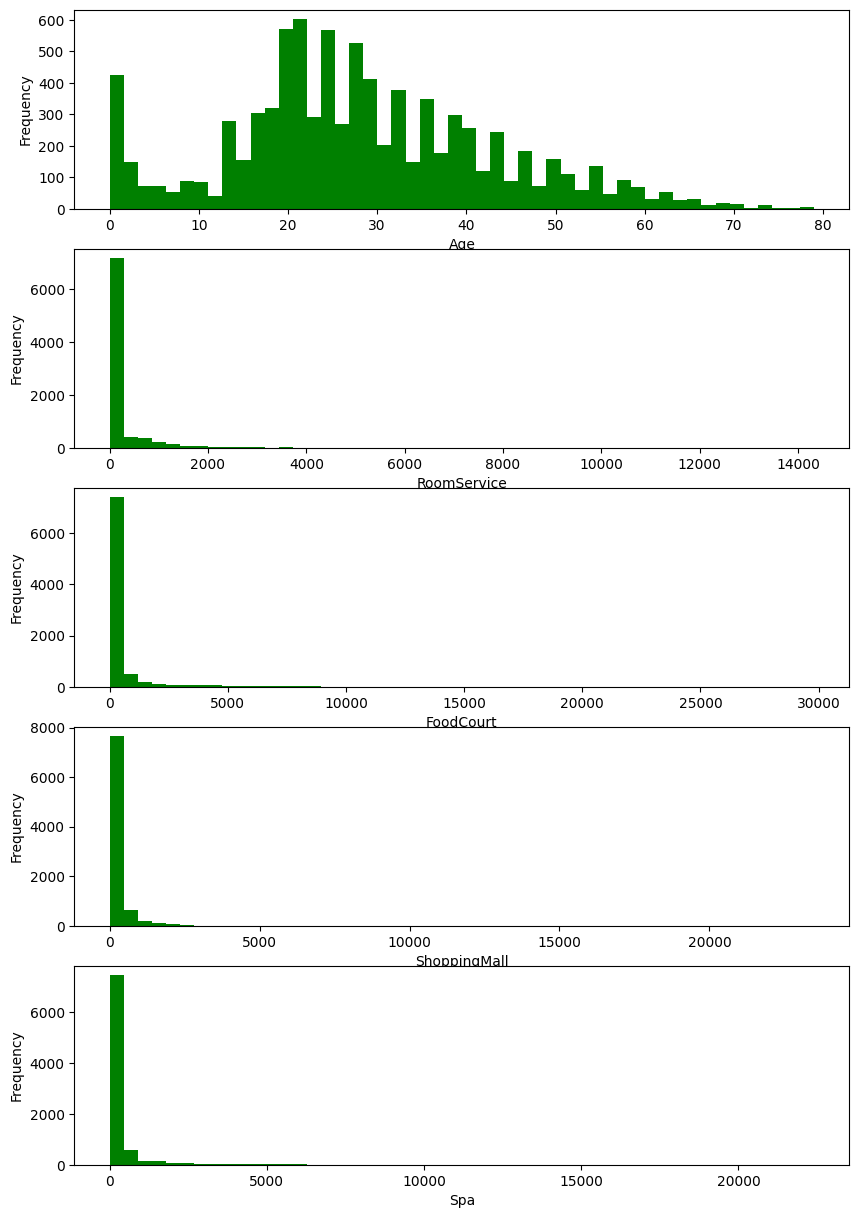

In [28]:
fig, ax = plt.subplots(5,1,  figsize=(10, 15))

data['Age'].plot(kind='hist', color='g', bins=50, ax=ax[0], xlabel='Age')
data['RoomService'].plot(kind='hist', color='g', bins=50, ax=ax[1], xlabel='RoomService')
data['FoodCourt'].plot(kind='hist', color='g', bins=50, ax=ax[2], xlabel='FoodCourt')
data['ShoppingMall'].plot(kind='hist', color='g', bins=50, ax=ax[3], xlabel='ShoppingMall')
data['Spa'].plot(kind='hist', color='g', bins=50, ax=ax[4], xlabel='Spa')

In [29]:
X, y = data.drop('Transported', axis=1), data['Transported']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

## XG Boost

In [30]:
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
print("Accuracy Score on Train Set: ", accuracy_score(y_pred, y_train))

y_pred = model.predict(X_test)
print("Accuracy Score on Test Set: ", accuracy_score(y_pred, y_test))

Accuracy Score on Train Set:  0.9177767013804795
Accuracy Score on Test Set:  0.7908045977011494


## TensorFlow ANN

In [31]:
model = Sequential([
    Input(shape=(20,)),
    Dense(25, activation='relu', name='Layer_1'),
    Dense(15, activation='relu', name='Layer_2'),
    Dense(1, activation='sigmoid', name='Layer_3')
])

model.compile(loss=BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[BinaryAccuracy()])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Layer_1 (Dense)                      │ (None, 25)                  │             525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Layer_2 (Dense)                      │ (None, 15)                  │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Layer_3 (Dense)                      │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 931 (3.64 KB)

 Trainable params: 931 (3.64 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.fit(X_train, y_train.astype(int), epochs=5)

Epoch 1/5


C:\Users\LMT\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:695: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.6584 - loss: 21.9963
Epoch 2/5
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7473 - loss: 1.7771
Epoch 3/5
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7212 - loss: 1.6308
Epoch 4/5
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - binary_accuracy: 0.7472 - loss: 1.2163
Epoch 5/5
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7419 - loss: 1.0428


In [33]:
y_pred = model.predict(X_train)
y_pred = (y_pred > 0.5)
print("Accuracy Score on Train Set: ", accuracy_score(y_pred, y_train))

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print("Accuracy Score on Test Set: ", accuracy_score(y_pred, y_test))

259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Accuracy Score on Train Set:  0.7563574715427465
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy Score on Test Set:  0.7632183908045977


## Models Evaluation

In [34]:
# accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score


### Run prediction on Test Set 

In [35]:
data = pd.read_csv(INPUT_PATH + "test.csv")
passenger_id = data.PassengerId

data = cleanData(data)

In [36]:
y_pred = model.predict(data)

y_pred = (y_pred > 0.5)

output = pd.DataFrame({'PassengerId': passenger_id,
                       'Transported': y_pred.squeeze()})
output.head()

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True

In [37]:
# Save to file
output.to_csv(OUTPUT_PATH + "submission.csv", index=False)